# 4c. Detecting Year and Country Bias in Model Performance

# Intro


This Notebook **analyzes the performance of our models**, and it **analyzes whether they are biased in how they classify papers published in different years and countries**. This is the **last Notebook of the series** and it completes our analyses of retraction by means of machine learning classifiers. 

The Notebook takes as input the saved models that we trained in **Notebook 4b**.

The **worfklow** has been set up as follows:

- Input: **one .csv file** with our corpus, and **three .pkl files** with the trained models that we saved in the previous Notebook.
- Output: **no output**.

# Input / Output Parameters:

Input parameters:

In [114]:

# File path to abstract corpus

input_path_corpus = "../data/final_corpus.csv"

# File path to logistic regressor

input_path_log_reg = "../data/trained_models/logistic_regressor.pkl"

# File path to xgboost classifier

input_path_xgboost = "../data/trained_models/xgboost_classifier.pkl"

# File path to random forest classifier

input_path_rf_classifier = "../data/trained_models/random_forest_classifier.pkl"

# File path to word count vectorizer

input_path_vectorizer = "../data/trained_models/vectorizer.pkl"

# File path to tf-idf vectorizer

input_path_tfidf = "../data/trained_models/tfidf.pkl"



There are no output parameters.

# Importing Required Libraries

In [115]:

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import sklearn
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier

import joblib



# Loading Trained Models

In order to start our analysis we need to load the trained models and vectorizers that we saved in the previous Notebook:

In [116]:

# Load logistic regressor

log_reg = joblib.load(input_path_log_reg)

# Load XGBoost classifier

xgboost = joblib.load(input_path_xgboost)

# Load random forest classifier

rf_classifier = joblib.load(input_path_rf_classifier)

# Load word count vectorizer

vectorizer = joblib.load(input_path_vectorizer)

# Load tf-idf vectorizer

tfidf = joblib.load(input_path_tfidf)


Let us also load our abstract corpus into a data frame:

In [117]:

# Create data frame with all abstracts

df_corpus = pd.read_csv(input_path_corpus, encoding='latin-1')

# Visualize data frame for verification

df_corpus.head()


,abstract_text,target,doi,country,year,ret_flag
0,"""Atrial fibrosis occurs frequently with struct...",1,10.1038_s41420-022-00895-9,CN,2022,False
1,"""In Brief Purpose To determine the safety and ...",1,10.1097_00006982-200402000-00018,US,2004,False
2,"""Biglycan (BGN) is an important component of t...",0,10.1016_j.molonc.2016.08.002,CN,2016,False
3,"""Fusarium wilt caused by Fusarium oxysporum f....",0,10.3390_toxins12040254,CN,2020,False
4,"""The genome of Stenotrophomonas maltophilia en...",1,10.1128_JB.00310-07,IE,2007,False


## Model Performance for Different Countries


Finally, let us also make sure that our model gives comparable predictions for papers from different years and countries. Let us start with China:

In [118]:

# Obtain only abstracts for papers from China and store them in data frame

df_ch = df_corpus[df_corpus["country"] == "CN"]

# Visualize shape of filtered array

print(df_ch.shape)

# Vectorize text for those papers using TF-IDF vectorization

X_ch_tfidf = tfidf.transform(df_ch["abstract_text"])

# Obtain predictions for vectorized text with logistic reg model

y_pred_ch = log_reg.predict(X_ch_tfidf)

(7032, 6)


In [119]:

# Obtain number of papers flagged as fraudulent

y_pred_ch.sum()


np.int64(3658)

In [120]:

# Obtain number of papers that we tested in total

len(y_pred_ch)


7032

In [121]:

# Compute percentage of papers flagged as fraudulent for China

per_fraud_china = y_pred_ch.sum() / len(y_pred_ch) * 100

# Visualize result

per_fraud_china 

np.float64(52.0193401592719)

In [122]:
df_ch_fraud = df_ch[df_ch["target"] == 1]

In [123]:
df_ch_fraud.shape

(3401, 6)

In [124]:
df_ch_fraud.shape[0] / df_ch.shape[0] * 100

48.3646188850967

- Let us now repeat the same steps for the US:

In [125]:

# Obtain only abstracts for papers from China and store them in data frame

df_us = df_corpus[df_corpus["country"] == "US"]

# Visualize shape of filtered array

print(df_us.shape)

# Vectorize text for those papers using TF-IDF vectorization

X_us_tfidf = tfidf.transform(df_us["abstract_text"])

# Obtain predictions for vectorized text with logistic reg model

y_pred_us = log_reg.predict(X_us_tfidf)

(2223, 6)


In [126]:

# Compute percentage of papers flagged as fraudulent for China

per_fraud_us = y_pred_us.sum() / len(y_pred_us) * 100

# Visualize result

per_fraud_us

np.float64(40.89068825910931)

In [127]:
df_us_fraud = df_us[df_us["target"] == 1]

In [128]:
df_us_fraud.shape[0] / df_us.shape[0] * 100

45.11920827710301


- It will be easier to simply write a function that performs all these operations for future use:

In [129]:

def model_tester_country(country_code, df, vectorizer, model):
    
    # Obtain only abstracts for papers from China and store them in data frame

    df_filtered = df[df["country"] == country_code]

    # Check if we have at least one abstract to process
    
    if df_filtered.empty:
        print(f"No abstracts found for {country_code}. Skipping.")
        return (None, None)

    # Vectorize text for those papers using TF-IDF vectorization

    X_filtered = vectorizer.transform(df_filtered["abstract_text"])

    # Obtain predictions for vectorized text with logistic reg model

    y_pred_filtered = model.predict(X_filtered)
    
    # Obtain total number of papers flagged
    
    total_flagged = y_pred_filtered.sum()

    # Compute percentage of papers flagged as fraudulent for country

    percentage_flagged = total_flagged / len(y_pred_filtered) * 100
    
    # Calculate total number of papers that are actually fraudulent for country
    
    total_fraud = df_filtered[df_filtered["target"] == 1].shape[0]
    
    # Calculate percentage of papers that are actually fraudulent for country
    
    percentage_fraud = total_fraud / df_filtered.shape[0] * 100

    # Print results
    
    #print(f"Perfectage of papers flagged for {country_code} {percentage_flagged}")
    #print(f"Perfectage of fraudulent papers for {country_code} {percentage_fraud}")
    
    return percentage_flagged, percentage_fraud, total_flagged, total_fraud
 

- Let us test it to make sure it works OK:

In [130]:

# Calculate percentage of papers flagged for US

model_tester_country("US", df_corpus, tfidf, log_reg)

(np.float64(40.89068825910931), 45.11920827710301, np.int64(909), 1003)

In [131]:

# Now for China

model_tester_country("CN", df_corpus, tfidf, log_reg)

(np.float64(52.0193401592719), 48.3646188850967, np.int64(3658), 3401)

In [132]:

# UK

model_tester_country("GB", df_corpus, tfidf, log_reg)

(np.float64(32.45614035087719), 37.719298245614034, np.int64(74), 86)

In [133]:

# India

model_tester_country("IN", df_corpus, tfidf, log_reg)

(np.float64(43.67816091954023), 47.701149425287355, np.int64(152), 166)

In [134]:

# Iran

model_tester_country("IR", df_corpus, tfidf, log_reg)

(np.float64(62.33766233766234), 60.3896103896104, np.int64(96), 93)

In [135]:
# France

model_tester_country("AU", df_corpus, tfidf, log_reg)

(np.float64(34.523809523809526), 41.66666666666667, np.int64(29), 35)

- Let us run a similar quality test for our year breakdown:

In [136]:

def model_tester_year(year, df, vectorizer, model):
    
    # Obtain only abstracts for papers from China and store them in data frame

    df_filtered = df[df["year"] == year]

    # Vectorize text for those papers using TF-IDF vectorization

    X_filtered = vectorizer.transform(df_filtered["abstract_text"])

    # Obtain predictions for vectorized text with logistic reg model

    y_pred_filtered = model.predict(X_filtered)

    # Obtain total number of papers flagged
    
    total_flagged = y_pred_filtered.sum()

    # Compute percentage of papers flagged as fraudulent for country

    percentage_flagged = total_flagged / len(y_pred_filtered) * 100
    
    # Calculate total number of papers that are actually fraudulent for country
    
    total_fraud = df_filtered[df_filtered["target"] == 1].shape[0]
    
    # Calculate percentage of papers that are actually fraudulent for country
    
    percentage_fraud = total_fraud / df_filtered.shape[0] * 100
    
    return percentage_flagged, percentage_fraud, total_flagged, total_fraud
 

In [137]:
model_tester_year(2020, df_corpus, tfidf, log_reg)

(np.float64(48.92286309937457), 45.448227936066715, np.int64(704), 654)

In [138]:
model_tester_year(2019, df_corpus, tfidf, log_reg)

(np.float64(52.566481137909705), 49.474335188620906, np.int64(850), 800)

In [139]:
model_tester_year(2009, df_corpus, tfidf, log_reg)

(np.float64(40.76246334310851), 48.38709677419355, np.int64(139), 165)


- Finally, let us create a function that allows us to run an analysis for both a country and a year of our choice:

In [140]:

def model_tester_year_country(year, country, df, vectorizer, model):
    
    # Obtain only abstracts for papers from a given bucket and store them in data frame

    df_filtered = df[(df["year"] == year) & (df["country"] == country)]

    # Vectorize text for those papers using our vectorizer

    X_filtered = vectorizer.transform(df_filtered["abstract_text"])

    # Obtain predictions for vectorized text with our model

    y_pred_filtered = model.predict(X_filtered)

    # Obtain total number of papers flagged
    
    total_flagged = y_pred_filtered.sum()

    # Compute percentage of papers flagged as fraudulent for country

    percentage_flagged = total_flagged / len(y_pred_filtered) * 100
    
    # Calculate total number of papers that are actually fraudulent for country
    
    total_fraud = df_filtered[df_filtered["target"] == 1].shape[0]
    
    # Calculate percentage of papers that are actually fraudulent for country
    
    percentage_fraud = total_fraud / df_filtered.shape[0] * 100

    # Print results
    
    #print(f"Perfectage of papers flagged for {year} and {country} {percentage_flagged}")
    #print(f"Perfectage of fraudulent papers for {year} and {country} {percentage_fraud}")
    
    return percentage_flagged, percentage_fraud, total_flagged, total_fraud
    

In [141]:

model_tester_year_country(2017, "CN", df_corpus, tfidf, log_reg)

(np.float64(55.0561797752809), 49.56304619225968, np.int64(441), 397)

In [142]:

model_tester_year_country(2021, "US", df_corpus, tfidf, log_reg)

(np.float64(32.35294117647059), 32.35294117647059, np.int64(11), 11)

In [143]:

model_tester_year_country(2018, "IR", df_corpus, tfidf, log_reg)

(np.float64(70.0), 70.0, np.int64(7), 7)

- Let us try a more systematic comparison for all countries:

In [144]:
df_corpus["country"] = df_corpus["country"].fillna("Unknown")

#temporary fix maybe remove later


In [145]:

countries = df_corpus["country"].unique()
results = []
difference_percentage = []
difference_total = []

for country in countries:
    country_results = model_tester_country(country, df_corpus, tfidf, log_reg)
    if country_results is None or len(country_results) < 4:
        print(f"Skipping {country} due to insufficient data.")
        continue
    results.append(country_results)
    difference_percentage.append(country_results[0] - country_results[1])
    difference_total.append(country_results[2] - country_results[3])



In [146]:


df_differences = pd.DataFrame({"country": countries, "percentage_difference": difference_percentage, "total_difference": difference_total})

In [147]:

df_differences = df_differences[df_differences["total_difference"] != 0]

<Axes: xlabel='country'>

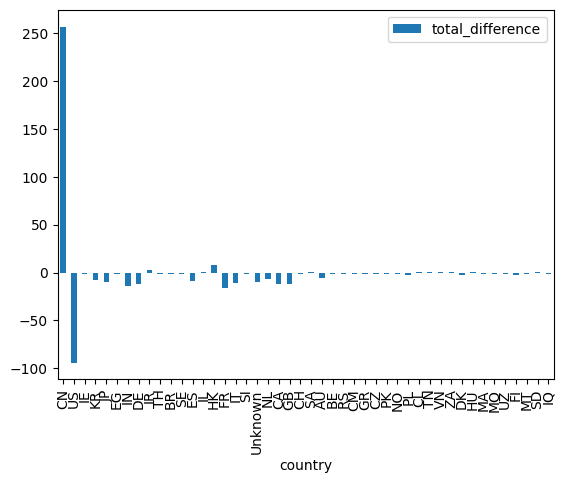

In [148]:

df_differences.plot.bar(x="country", y="total_difference")


In [149]:

# Obtain size of data frame to decide how to filter top entires

df_differences.shape

(46, 3)

In [150]:

# Filter data frame to obtain countries with most papers in absolute number only 

df_differences_filtered = df_differences.head(27)

<Axes: xlabel='country'>

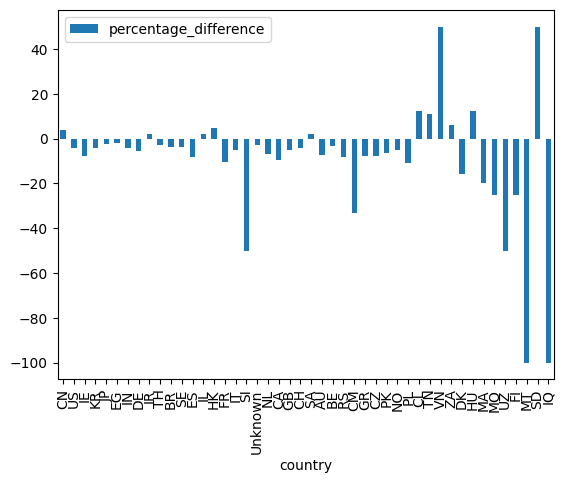

In [151]:

# Make normal plot

df_differences.plot.bar(x="country", y="percentage_difference")


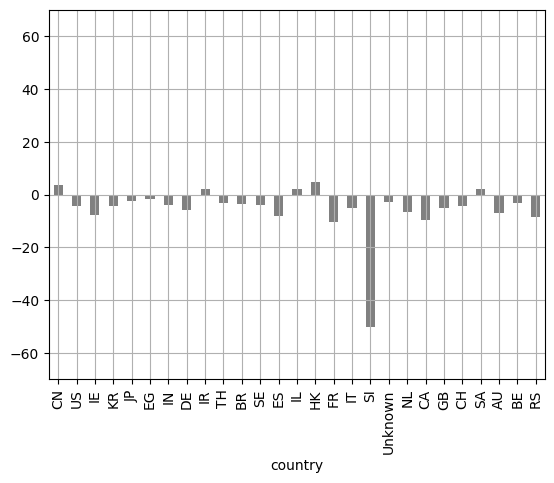

In [152]:

# Make plot for filtered data frame

ax = df_differences_filtered.plot.bar(x="country", y="percentage_difference", color='grey', legend=False)

# Set the y axis to -50 and 50 percentage points

ax.set_ylim(-70, 70)

# Add grid

ax.grid(True)

# Display plot

plt.show()


- And now for all years:

In [153]:

year_results = model_tester_year(2020, df_corpus, tfidf, log_reg)


In [154]:
years = df_corpus["year"].unique()
results_year = []
difference_percentage_year = []
difference_total_year = []


    
for year in years:
    year_results = model_tester_year(year, df_corpus, tfidf, log_reg)
    results_year.append(year_results)
    difference_percentage_year.append(year_results[0] - year_results[1])
    difference_total_year.append(year_results[2] - year_results[3])



In [155]:
df_differences_year = pd.DataFrame({"year": years, "percentage_difference": difference_percentage_year, "total_difference": difference_total_year})

In [156]:
df_differences_year.head(5)

,year,percentage_difference,total_difference
0,2022,0.719424,5
1,2004,-5.978261,-11
2,2016,1.737757,11
3,2020,3.474635,50
4,2007,-2.941176,-8


<Axes: xlabel='year'>

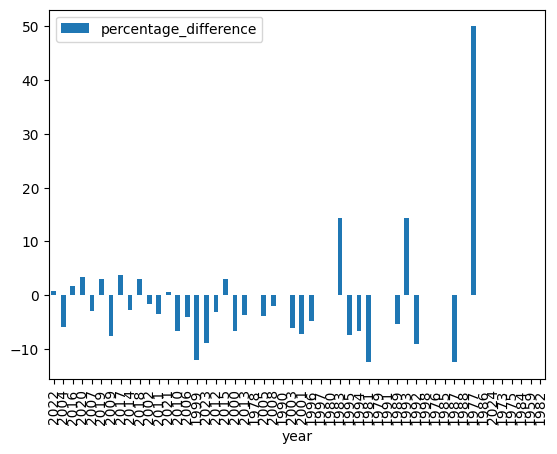

In [157]:
df_differences_year.plot.bar(x="year", y="percentage_difference")


<Axes: xlabel='year'>

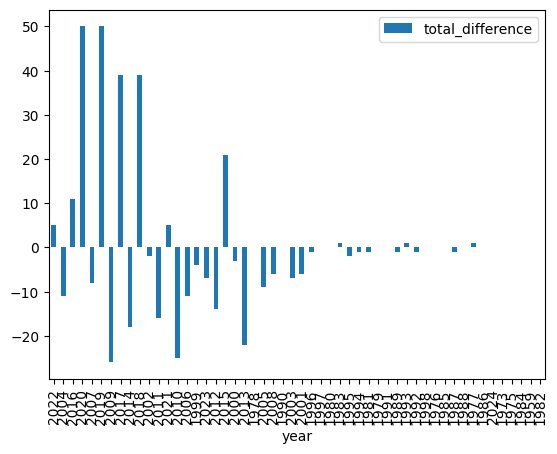

In [158]:

df_differences_year.plot.bar(x="year", y="total_difference")


-Let us get some scores and performance metrics per year and country too. First we'll try China:


In [159]:

df_china = df_corpus[df_corpus["country"] == "CN"]

# Vectorize text for those papers using TF-IDF vectorization

X_china = tfidf.transform(df_china["abstract_text"])

# Obtain predictions for vectorized text with logistic reg model

y_pred_china = log_reg.predict(X_china)
    

In [160]:
y_china = df_china["target"]

report_test = classification_report(y_china, y_pred_china)

print("Classification Report for China:\n", report_test)

Classification Report for China:
               precision    recall  f1-score   support

           0       0.96      0.89      0.92      3631
           1       0.89      0.96      0.92      3401

    accuracy                           0.92      7032
   macro avg       0.93      0.93      0.92      7032
weighted avg       0.93      0.92      0.92      7032



In [161]:
conf_matrix_china = confusion_matrix(y_china, y_pred_china)

conf_matrix_china

array([[3235,  396],
       [ 139, 3262]])

- And then the US:

In [162]:

df_us = df_corpus[df_corpus["country"] == "US"]

# Vectorize text for those papers using TF-IDF vectorization

X_us = tfidf.transform(df_us["abstract_text"])

# Obtain predictions for vectorized text with logistic reg model

y_pred_us = log_reg.predict(X_us)
    

In [163]:
y_us = df_us["target"]

report_test_us = classification_report(y_us, y_pred_us)

print("Classification Report for the USA:\n", report_test_us)

Classification Report for the USA:
               precision    recall  f1-score   support

           0       0.90      0.97      0.93      1220
           1       0.96      0.87      0.91      1003

    accuracy                           0.93      2223
   macro avg       0.93      0.92      0.92      2223
weighted avg       0.93      0.93      0.92      2223



In [164]:
conf_matrix_us = confusion_matrix(y_us, y_pred_us)

conf_matrix_us

array([[1184,   36],
       [ 130,  873]])